### Import required packages

In [3]:
import pandas as pd
import numpy as np
import arviz as az
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

### Read in results from the two different methods

In [4]:
iid_summary = pd.read_csv("../data/iid_summary.csv")
ar1_summary = pd.read_csv("../data/ar1_summary.csv")

df_FinBERT = pd.read_csv('../data/sp500_headlines_2008_2024_FinBERT.csv')
df_FinBERT["Date"] = pd.to_datetime(df_FinBERT["Date"])

df_VADER = pd.read_csv('../data/sp500_headlines_2008_2024_VADER.csv')
df_VADER["Date"] = pd.to_datetime(df_VADER["Date"])

In [5]:
daily_iid  = pd.read_csv("../data/daily_latent_sentiment_iid.csv")
daily_ar1  = pd.read_csv("../data/daily_latent_sentiment_ar1.csv")
daily_FinBERT = pd.read_csv("../data/daily_headlines_embedded_FinBERT.csv", parse_dates=['Date'])
daily_VADER = pd.read_csv("../data/daily_headlines_embedded_VADER.csv", parse_dates=['Date'])

In [16]:
daily_VADER['hat_theta'].describe()

count    3507.000000
mean        0.026459
std         0.200730
min        -0.812600
25%        -0.057050
50%         0.000000
75%         0.132093
max         0.788400
Name: hat_theta, dtype: float64

### Descriptive Statistics

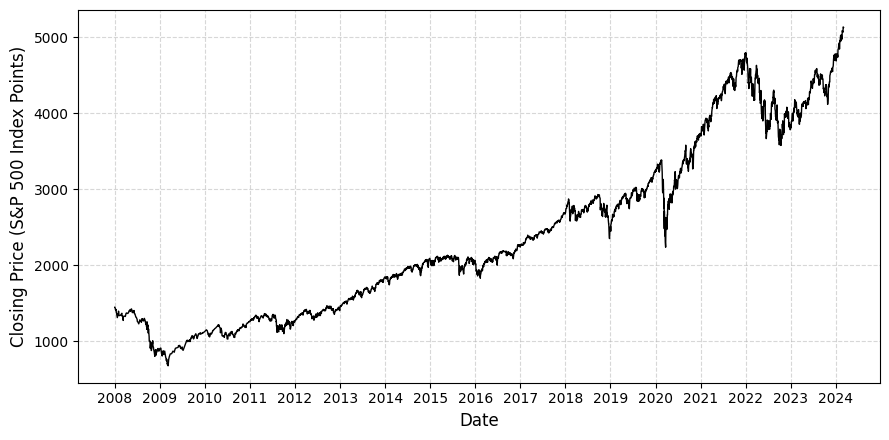

In [75]:
plt.figure(figsize=(9, 4.5))
plt.plot(daily_FinBERT["Date"], daily_FinBERT["CP"], color="black", linewidth=1)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Closing Price (S&P 500 Index Points)", fontsize=12)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\49176\AppData\Local\Temp\ipykernel_39264\578048287.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


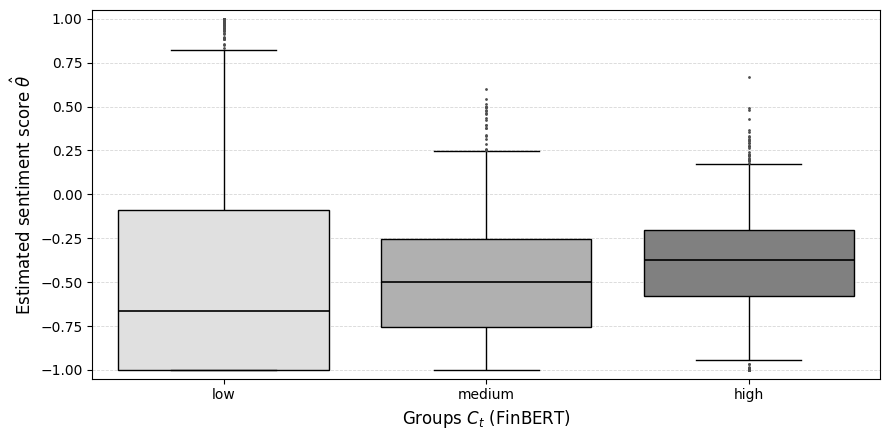

In [73]:
order = ["low", "medium", "high"]
palette = ["#e0e0e0", "#b0b0b0", "#808080"]
plt.figure(figsize=(9, 4.5))
ax = sns.boxplot(
    data=daily_FinBERT, x="C_group", y="hat_theta", order=order,
    palette=palette,
    linewidth=1,
    fliersize=1,
    whis=1,
    boxprops=dict(edgecolor="black"),
    medianprops=dict(color="black", linewidth=1.2),
    whiskerprops=dict(color="black", linewidth=1),
    capprops=dict(color="black", linewidth=1)
)
ax.set_xlabel(r"Groups $C_t$ (FinBERT)", fontsize=12)
ax.set_ylabel(r"Estimated sentiment score $\hat{\theta}$", fontsize=12)
ax.set_ylim(-1.05, 1.05)
ax.grid(True, axis="y", linestyle="--", linewidth=0.6, alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\49176\AppData\Local\Temp\ipykernel_39264\626602614.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


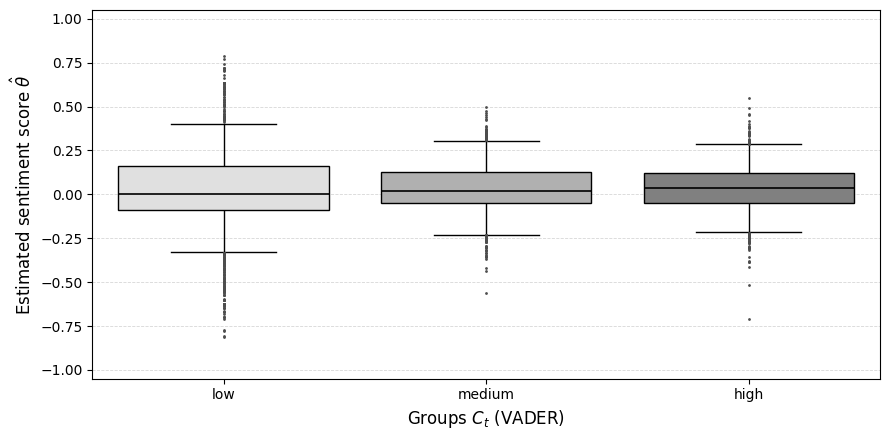

In [74]:
order = ["low", "medium", "high"]
palette = ["#e0e0e0", "#b0b0b0", "#808080"]
plt.figure(figsize=(9, 4.5))
ax = sns.boxplot(
    data=daily_VADER, x="C_group", y="hat_theta", order=order,
    palette=palette,
    linewidth=1,
    fliersize=1,
    whis=1,
    boxprops=dict(edgecolor="black"),
    medianprops=dict(color="black", linewidth=1.2),
    whiskerprops=dict(color="black", linewidth=1),
    capprops=dict(color="black", linewidth=1)
)
ax.set_xlabel(r"Groups $C_t$ (VADER)", fontsize=12)
ax.set_ylabel(r"Estimated sentiment score $\hat{\theta}$", fontsize=12)
ax.set_ylim(-1.05, 1.05)
ax.grid(True, axis="y", linestyle="--", linewidth=0.6, alpha=0.5)
plt.tight_layout()
plt.show()

### Data preparation

In [38]:
def ols_hac(y, X, lags=5):
    Xc = sm.add_constant(X)
    return sm.OLS(y, Xc, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': lags})

results_by_C = {}

for grp, dailyg in daily_FinBERT.groupby("C_group"):
    X = sm.add_constant(dailyg['hat_theta'])
    y = dailyg['Return_simple']
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    results_by_C[grp] = model

for grp, model in results_by_C.items():
    print(f"=== Group: {grp} ===")
    print(model.summary().tables[1])
    print("\n")

=== Group: high ===
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.177      0.029    3.55e-05       0.001
hat_theta      0.0004      0.000      1.179      0.238      -0.000       0.001


=== Group: low ===
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.663e-05      0.000     -0.061      0.952      -0.001       0.001
hat_theta     -0.0002      0.001     -0.369      0.712      -0.001       0.001


=== Group: medium ===
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.616e-06      0.000     -0.033      0.973      -0.000       0.000
hat_theta     -0.0002      0.000     -0.683      0.495      -0.001

### Visualization

Table

In [31]:
def pick(df, name):
    return pd.Series({
        "Estimator": name,
        "gamma1_mean": df.loc["gamma1","mean"],
        "gamma1_sd":   df.loc["gamma1","sd"],
        "gamma1_l":    df.loc["gamma1"].get("hdi_3%", df.loc["gamma1"].get("hdi_2.5%", np.nan)),
        "gamma1_u":    df.loc["gamma1"].get("hdi_97%", df.loc["gamma1"].get("hdi_97.5%", np.nan)),
    })

rows = [
    pick(iid_summary, "One-Step (IID)"),
    pick(ar1_summary, "One-Step (AR1)"),
]

# OPTIONAL: wenn du Two-Step-Summaries hast (gleiche Struktur, Index=param names)
# twostep_summary = pd.read_csv("../data/twostep_summary.csv", index_col=0)
# rows.append(pick(twostep_summary, "Two-Step (OLS)"))

tbl = pd.DataFrame(rows)
tbl["gamma1_CI"] = tbl.apply(lambda r: f"[{r.gamma1_l:.4g}, {r.gamma1_u:.4g}]", axis=1)
tbl_round = tbl[["Estimator","gamma1_mean","gamma1_sd","gamma1_CI"]].copy()
tbl_round.rename(columns={
    "gamma1_mean":"Estimate",
    "gamma1_sd":"Std. Error",
    "gamma1_CI":"95% Interval"
}, inplace=True)

# CSV + LaTeX für Paper
'''tbl_round.to_csv("../fig/estimator_comparison.csv", index=False)
with open("../fig/estimator_comparison.tex","w", encoding="utf-8") as f:
    f.write(tbl_round.to_latex(index=False, escape=False, float_format="%.4g"))'''
print(tbl_round)


        Estimator  Estimate  Std. Error           95% Interval
0  One-Step (IID)  0.012127    0.000325     [0.01155, 0.01273]
1  One-Step (AR1) -0.000767    0.001098  [-0.002834, 0.001226]


Image

In [30]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
rng = np.random.default_rng(123)

def simulate_once(T=800, gamma0=0.0, gamma1=0.02, rho=0.95, tau=0.05,
                  sigma_y=0.01, sigma_fin=0.6, C_low=2, C_high=30):
    # Latent AR(1)
    theta = np.zeros(T)
    theta[0] = rng.normal(0, tau/np.sqrt(1-rho**2))
    for t in range(1,T):
        theta[t] = rho*theta[t-1] + rng.normal(0, tau)
    # Headlines
    C_t = rng.integers(C_low, C_high+1, size=T)
    sbar = np.empty(T)
    for t in range(T):
        s_tj = theta[t] + rng.normal(0, sigma_fin, size=C_t[t])
        sbar[t] = s_tj.mean()
    # Returns
    R = gamma0 + gamma1*theta + rng.normal(0, sigma_y, size=T)
    # Oracle OLS
    Xo = sm.add_constant(theta)
    res_o = sm.OLS(R, Xo).fit()
    b_o, se_o = res_o.params[1], res_o.bse[1]
    ci_o = (b_o - 1.96*se_o, b_o + 1.96*se_o)
    # Feasible two-step OLS
    Xf = sm.add_constant(sbar)
    res_f = sm.OLS(R, Xf).fit()
    b_f, se_f = res_f.params[1], res_f.bse[1]
    ci_f = (b_f - 1.96*se_f, b_f + 1.96*se_f)
    return {
        "b_oracle": b_o, "l_oracle": ci_o[0], "u_oracle": ci_o[1],
        "b_feasible": b_f, "l_feasible": ci_f[0], "u_feasible": ci_f[1],
    }

def run_coverage(R=500, T=800, gamma1=0.02,
                 sigma_fin_grid=(0.3, 0.6, 0.9),
                 C_grids=((2,30),(5,50),(10,80))):
    rows=[]
    for sigma_fin in sigma_fin_grid:
        for C_low, C_high in C_grids:
            cover_o = cover_f = 0
            for _ in range(R):
                out = simulate_once(T=T, gamma1=gamma1, sigma_fin=sigma_fin,
                                    C_low=C_low, C_high=C_high)
                if out["l_oracle"] <= gamma1 <= out["u_oracle"]:
                    cover_o += 1
                if out["l_feasible"] <= gamma1 <= out["u_feasible"]:
                    cover_f += 1
            rows.append({
                "sigma_fin": sigma_fin,
                "C_low": C_low, "C_high": C_high, "C_mean": (C_low+C_high)/2,
                "coverage_oracle": cover_o/R,
                "coverage_feasible": cover_f/R
            })
    return pd.DataFrame(rows)

# Lauf
covdf = run_coverage(R=400)  # ggf. höher stellen (z.B. 1000) wenn Zeit vorhanden
'''covdf.to_csv("../fig/coverage_table.csv", index=False)'''
print(covdf)


KeyboardInterrupt: 